In [1]:
import import_src
from src.order_broker import Broker
from src.broker_vis import *
from src.models import *
import numpy as np
import random
import pandas as pd

In [2]:
# Create a broker, and a market for ACME stock
asset = "ACME"
broker = Broker()
broker.create_market(asset)

In [3]:
num_traders = 32
starting_cash_balance_cents = 3200
starting_asset_balance = 100

initial_cash_in_market = num_traders * starting_cash_balance_cents
initial_assets_in_market = num_traders * starting_asset_balance

# create accounts all traders
# give each of them 10000 cents of cash, and 100 shares of ACME stock
traderIds = [i for i in range(num_traders)]
for traderId in traderIds:
    broker.open_account(traderId)
    broker.deposit_cash(traderId, starting_cash_balance_cents)
    broker.deposit_asset(traderId, starting_asset_balance, asset)



In [4]:
# simulate market activity by having each trader make random trades
# monkeys on a bloomberg terminal
num_iterations = 1000
prefered_bid_price = 32
bid_price_std = 4
prefered_ask_price = 32
ask_price_std = 4
order_size_k = 1

# Adding a bias towards market orders reduces assets and cash tied up in unmatched limit orders
# it also seems to reduce the number of bids that are greater than asks
limit_fraction: float = 0.5
bid_fraction: float = 0.5

# record level 1 order history
l1_hist_dict: dict[str, list] = {
    "best_bid" : [], 
    "best_ask" : [], 
    "timestamp" : []
}


timestamp = 0
# each trader makes 1 trade per iteration
for i in range(num_iterations):

    # shuffle to remove bias from the order of the list
    # prevents "first mover advantage"
    random.shuffle(traderIds)
    for traderId in traderIds:     
        # construct order
        orderId:int = random.randint(1, 2**30)
        side: Side
        type: OrderType
        priceCents: int
        amount: int = np.random.poisson(order_size_k)
        if random.random() < bid_fraction: # Buy
            side = Side.BUY
            priceCents = int(np.random.normal(prefered_bid_price, bid_price_std))
        else: # Sell
            priceCents = int(np.random.normal(prefered_ask_price, ask_price_std))
            side = Side.SELL
        if random.random() < limit_fraction: # Limit
            type = OrderType.LIMIT
        else: # Market
            type = OrderType.MARKET
        order = Order(
            orderId,
            traderId,
            side,
            type,
            priceCents,
            amount,
            timestamp,
        )
        timestamp += 1
        
        # place order
        try:
            broker.place_order(asset, order)
        except:
            pass
            #print(f"Failed to place order at iteration {i} for trader {traderId}")

        # append to L1 history
        best_bid = broker.get_highest_bid(asset)
        best_ask = broker.get_lowest_ask(asset)
        l1_hist_dict["timestamp"].append(timestamp)
        l1_hist_dict["best_ask"].append(best_ask)
        l1_hist_dict["best_bid"].append(best_bid)

l1_hist = pd.DataFrame(l1_hist_dict)



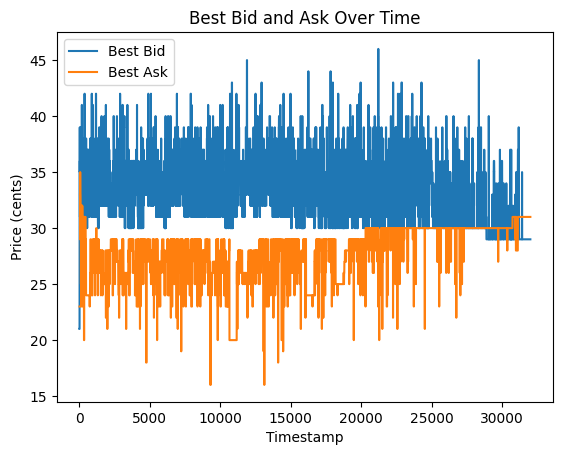

In [5]:
# plot best bid and ask over time
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(l1_hist['timestamp'], l1_hist['best_bid'], label='Best Bid')
ax.plot(l1_hist['timestamp'], l1_hist['best_ask'], label='Best Ask')
ax.set_xlabel('Timestamp')
ax.set_ylabel('Price (cents)')
ax.set_title('Best Bid and Ask Over Time')
ax.legend()
plt.show()

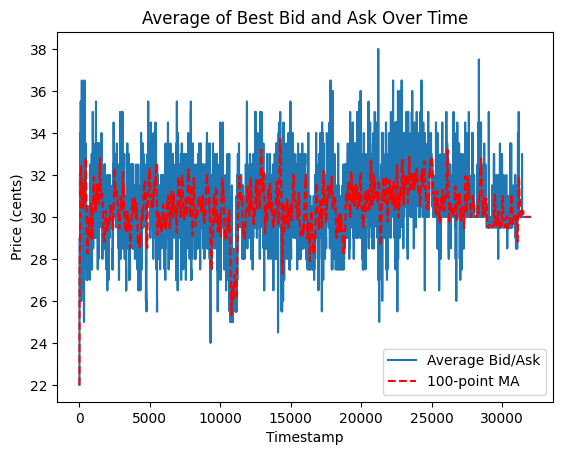

In [6]:
# plot average of best bid and ask over time with moving average
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# compute average, None if either bid or ask is missing
avg_series = l1_hist.apply(
    lambda row: (row["best_bid"] + row["best_ask"]) / 2
                if pd.notna(row["best_bid"]) and pd.notna(row["best_ask"])
                else None,
    axis=1
)

# convert None to np.nan so matplotlib skips those segments
avg_plot = avg_series.astype(float)

# compute moving average
ma_window = 100  # number of points in moving average window
ma_plot = pd.Series(avg_plot).rolling(window=ma_window, min_periods=1).mean()

fig, ax = plt.subplots()
ax.plot(l1_hist["timestamp"], avg_plot, label="Average Bid/Ask")
ax.plot(l1_hist["timestamp"], ma_plot,
        label=f"{ma_window}-point MA",
        color="red", linestyle="--")
ax.set_xlabel("Timestamp")
ax.set_ylabel("Price (cents)")
ax.set_title("Average of Best Bid and Ask Over Time")
ax.legend()
plt.show()

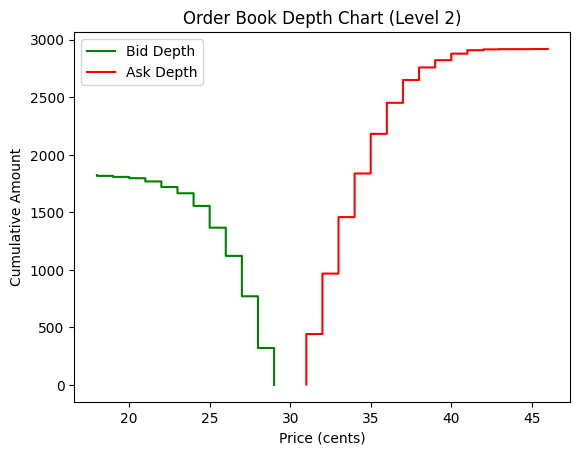

In [7]:
depth_chart(broker, asset)

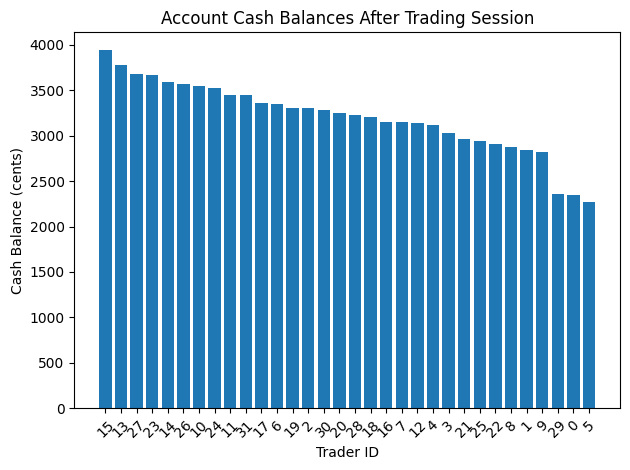

{0: Account(traderId=0, cashBalanceCents=2346, portfolio={'ACME': 121}, earMarkedCashCents=2345, earMarkedAssets={'ACME': 121}), 1: Account(traderId=1, cashBalanceCents=2846, portfolio={'ACME': 116}, earMarkedCashCents=2841, earMarkedAssets={'ACME': 116}), 2: Account(traderId=2, cashBalanceCents=3302, portfolio={'ACME': 99}, earMarkedCashCents=3302, earMarkedAssets={'ACME': 99}), 3: Account(traderId=3, cashBalanceCents=3031, portfolio={'ACME': 99}, earMarkedCashCents=3028, earMarkedAssets={'ACME': 99}), 4: Account(traderId=4, cashBalanceCents=3120, portfolio={'ACME': 102}, earMarkedCashCents=3101, earMarkedAssets={'ACME': 102}), 5: Account(traderId=5, cashBalanceCents=2266, portfolio={'ACME': 127}, earMarkedCashCents=2265, earMarkedAssets={'ACME': 127}), 6: Account(traderId=6, cashBalanceCents=3353, portfolio={'ACME': 98}, earMarkedCashCents=3352, earMarkedAssets={'ACME': 98}), 7: Account(traderId=7, cashBalanceCents=3151, portfolio={'ACME': 98}, earMarkedCashCents=3138, earMarkedAsset

In [8]:
show_account_cash_balances(broker)

print(broker.accounts)

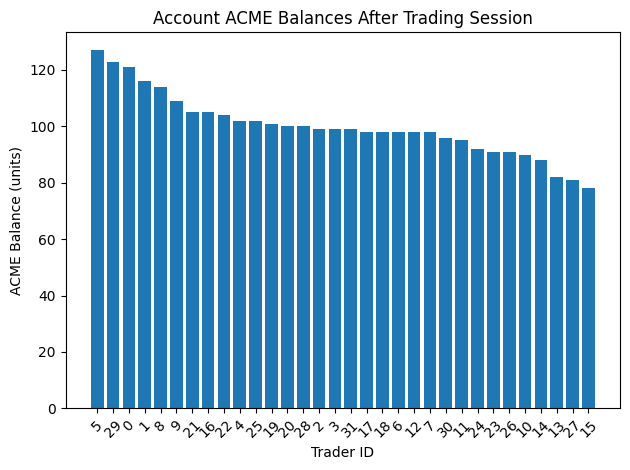

In [9]:
show_account_asset_balances(broker, asset)

In [10]:
# spearmn rank correlation between cash balance and ACME stock

from scipy.stats import spearmanr
cash_balances = []
asset_balances = []
for traderId in traderIds:
    cash_balances.append(broker.get_account_info(traderId).cashBalanceCents)
    asset_balances.append(broker.get_account_info(traderId).portfolio[asset])

corr, _ = spearmanr(cash_balances, asset_balances)
print(f"Spearman rank correlation between cash and {asset} balances: {corr}")

Spearman rank correlation between cash and ACME balances: -0.9212561660676876


In [11]:
# compare total cash and assets in market to final balances.
# Cash and assets are neither created nor destroyed in this simulation,
# they are only transferred between traders and the broker.
final_total_cash = sum(cash_balances)
final_total_assets = sum(asset_balances)

# add cash and assets held by broker (e.g. in unfilled limit orders)
cash_held_by_broker = broker.total_cash_held_in_bid_limits(asset)
assets_held_by_broker = broker.total_assets_held_in_ask_limits(asset)
final_total_cash += cash_held_by_broker
final_total_assets += assets_held_by_broker

print(f"Cash held by traders: {final_total_cash - cash_held_by_broker} cents")
print(f"Assets held by traders: {final_total_assets - assets_held_by_broker} units")
print(f"Cash held by broker in bid limits: {cash_held_by_broker} cents")
print(f"Assets held by broker in ask limits: {assets_held_by_broker} units")
print(f"Initial total cash in market: {initial_cash_in_market} cents")
print(f"Initial total assets in market: {initial_assets_in_market} units")
print(f"Final total cash in market: {final_total_cash} cents")
print(f"Final total assets in market: {final_total_assets} units")

assert final_total_cash == initial_cash_in_market, "Total cash in market does not match initial amount!"
assert final_total_assets == initial_assets_in_market, "Total assets in market does not match initial amount!"

Cash held by traders: 102400 cents
Assets held by traders: 3200 units
Cash held by broker in bid limits: 48547 cents
Assets held by broker in ask limits: 2920 units
Initial total cash in market: 102400 cents
Initial total assets in market: 3200 units
Final total cash in market: 150947 cents
Final total assets in market: 6120 units


AssertionError: Total cash in market does not match initial amount!

In [ ]:
# TODO https://quant.stackexchange.com/questions/2820/has-spectrum-analysis-ever-been-used-successfully-to-analyse-historical-price-da